In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from keras.datasets import cifar10
from keras.utils import np_utils

Using TensorFlow backend.


## Generate Gabor filter banks

In [4]:
def create_kernel():
    orientation_spread = np.linspace(0, 4, 8) / 4. * np.pi
    scales = np.linspace(0.1, 0.4, 6)
    real_kernels = []
    imagine_kernels = []
#     size, sigma, theta, lambda, gamma aspect ratio
    for orientation in orientation_spread:
        for scale in scales:
            real_kernel = cv2.getGaborKernel((31, 31), 3, orientation, scale, 1, 0)
            imaginary_kernel = cv2.getGaborKernel((31, 31), 3, orientation, scale, 1, np.pi / 2)
            real_kernels.append(real_kernel)
            imagine_kernels.append(imaginary_kernel)
    return np.array(real_kernels), np.array(imagine_kernels)

In [5]:
real_kernels, imagine_kernels = create_kernel()

## Generated filter banks of 96 combinations

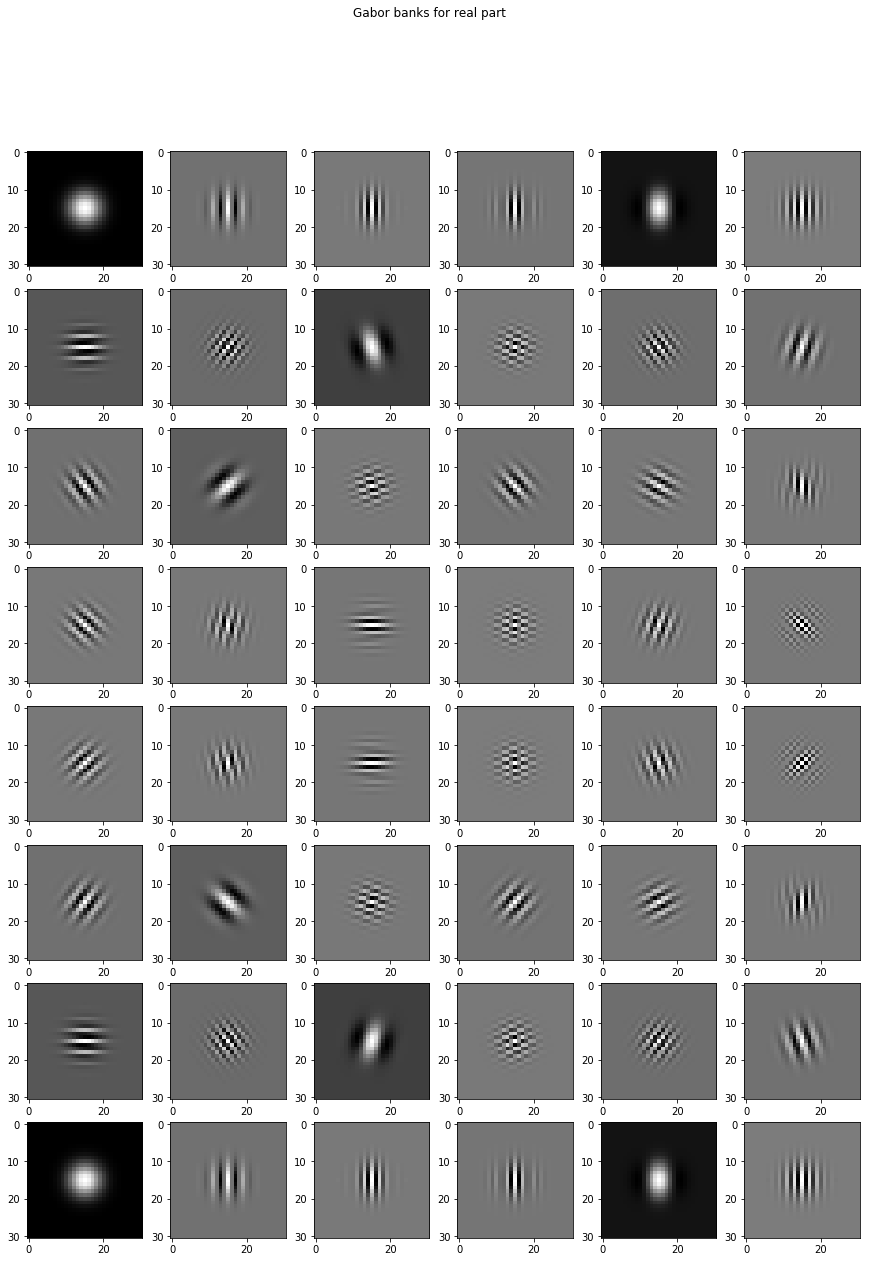

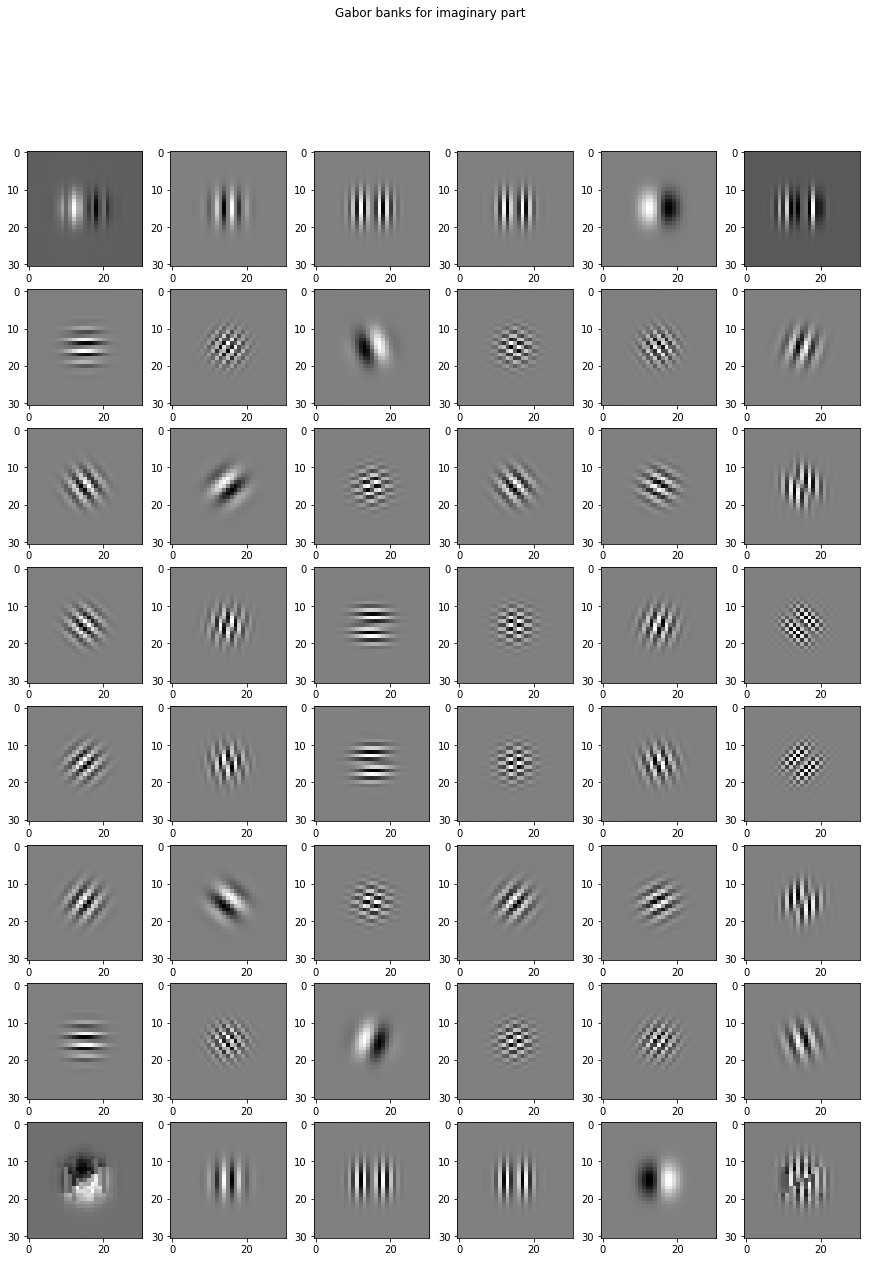

In [6]:
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 20))
plt.gray()
fig.suptitle('Gabor banks for real part', fontsize=12)
idx = 0
for row in range(0, 8):
    for col in range(0, 6):
        cell = axes[row][col]
        cell.imshow(real_kernels[idx])
        idx += 1

fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 20))
plt.gray()
fig.suptitle('Gabor banks for imaginary part', fontsize=12)
idx = 0
for row in range(0, 8):
    for col in range(0, 6):
        cell = axes[row][col]
        cell.imshow(imagine_kernels[idx])
        idx += 1

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Pre-processing pipeline

In [8]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    return rst

In [9]:
def apply_gabor(img, kernel):
    return cv2.filter2D(img, cv2.CV_32F, kernel)

## Convolve images with Gabor filter banks

In [10]:
def convolve(images):
    orientation_spread = np.linspace(0, 4, 8) / 4. * np.pi
    scales = np.linspace(0.1, 0.4, 6)
    real_list = []
    imagine_list = []
    kernels = []
    kernel_params = []
    iteration = 1
    for theta in orientation_spread:
        for frequency in scales:
            real_kernel = cv2.getGaborKernel((31, 31), 3, theta, frequency, 1, 0)
            imaginary_kernel = cv2.getGaborKernel((31, 31), 3, theta, frequency, 1, np.pi / 2)
            params = 'theta=%d, frequency=%.2f' % (theta * 180 / np.pi, frequency)
            kernel_params.append(params)
            # Save kernel and the power image for each image
            real_list.append([apply_gabor(img, real_kernel) for img in images])
            imagine_list.append([apply_gabor(img, imaginary_kernel) for img in images])
            print('finished iter:' + str(iteration))
            iteration += 1
    real_list = np.array(real_list)
    imagine_list = np.array(imagine_list)
    stacked_list = np.vstack((real_list, imagine_list))
    return stacked_list, kernels, kernel_params

In [11]:
train_selected_amount = 10
test_selected_amount = 10
num_classes = 10
gray_x_train = grayscale(x_train[:train_selected_amount])
gray_x_test = grayscale(x_test[:test_selected_amount])
y_train = np_utils.to_categorical(y_train[:train_selected_amount], num_classes)
y_test = np_utils.to_categorical(y_test[:test_selected_amount], num_classes)
print(y_train.shape)

(10, 10)


## save the convolved images into disk

In [12]:
convolved_x_train, kernel_train, kernel_params = convolve(gray_x_train)
convolved_x_train = np.einsum('abcd->bcda', convolved_x_train)
convolved_x_test, kernel_test, kernel_params = convolve(gray_x_test)
convolved_x_test = np.einsum('abcd->bcda', convolved_x_test)
np.save('convolved_x_train_cv2', convolved_x_train)
np.save('convolved_x_test_cv2', convolved_x_test)
# print(convolved_x_train.shape)

finished iter:1
finished iter:2
finished iter:3
finished iter:4
finished iter:5
finished iter:6
finished iter:7
finished iter:8
finished iter:9
finished iter:10
finished iter:11
finished iter:12
finished iter:13
finished iter:14
finished iter:15
finished iter:16
finished iter:17
finished iter:18
finished iter:19
finished iter:20
finished iter:21
finished iter:22
finished iter:23
finished iter:24
finished iter:25
finished iter:26
finished iter:27
finished iter:28
finished iter:29
finished iter:30
finished iter:31
finished iter:32
finished iter:33
finished iter:34
finished iter:35
finished iter:36
finished iter:37
finished iter:38
finished iter:39
finished iter:40
finished iter:41
finished iter:42
finished iter:43
finished iter:44
finished iter:45
finished iter:46
finished iter:47
finished iter:48
finished iter:1
finished iter:2
finished iter:3
finished iter:4
finished iter:5
finished iter:6
finished iter:7
finished iter:8
finished iter:9
finished iter:10
finished iter:11
finished iter:1

## Sample image respoonses of manual convolution

(32, 32, 96)


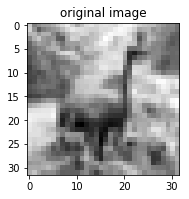

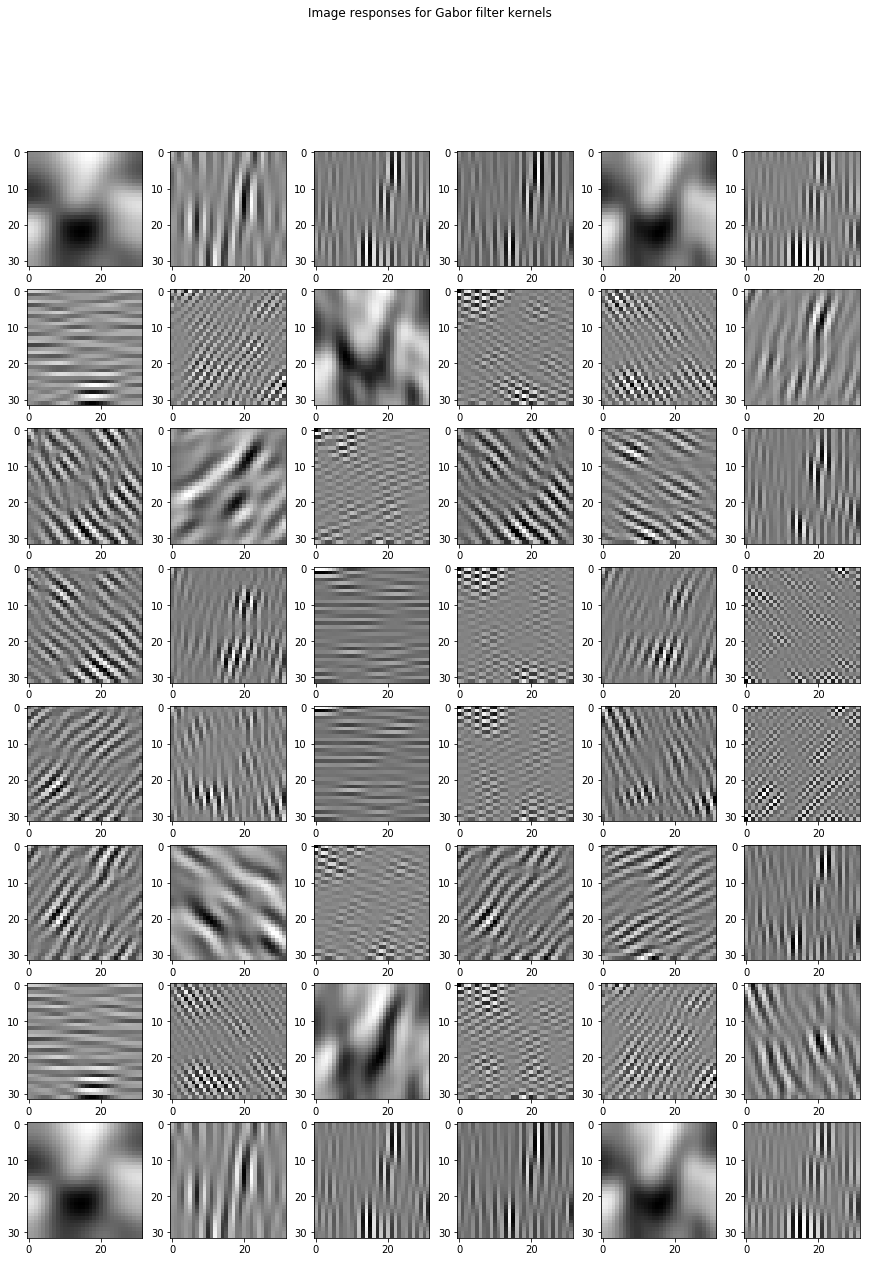

In [13]:
selected = 6
test = convolved_x_train[selected, :]
print(test.shape)

plt.figure()
plt.subplot(121)
plt.title('original image')
plt.imshow(gray_x_train[selected], cmap='gray')

fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 20))
plt.gray()
fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
idx = 0
for row in range(0, 8):
    for col in range(0, 6):
        cell = axes[row][col]
        cell.imshow(test[::, ::, idx])
        idx += 1